In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
import sys
sys.path.append('/content/drive/MyDrive/Colab Notebooks')

In [3]:
import numpy as np
import torch
from torch import nn
from torch.utils.data import DataLoader
from torchvision.models import resnet50, VGG19_Weights, ResNet50_Weights

import matplotlib.pyplot as plt
from pathlib import Path
import random
import time
import os

from sperm.dataset.mhsma import *
from sperm.samplers.task_sampler import TaskSampler
from sperm.methods.prototypical_networks import PrototypicalNetworks
from sperm.methods.relation_networks import RelationNetworks
from sperm.methods.matching_networks import MatchingNetworks
from sperm.utils import precision,recall, dsc,plot_images, save_result, reset_result
from sperm.train import evaluate, train

In [4]:
random_seed = 0
np.random.seed(random_seed)
torch.manual_seed(random_seed)
random.seed(random_seed)
torch.cuda.manual_seed_all(random_seed)
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False

In [5]:
train_val_label = 'hva'
params = {'balancer':True, 'image_size': 128}

train_set = MHSMA(dtype = "train", label = train_val_label, params = params)
val_set   = MHSMA(dtype="valid", label = train_val_label, params = params)

In [ ]:
# train_set = normalize(train_set)
# val_set   = normalize(val_set)

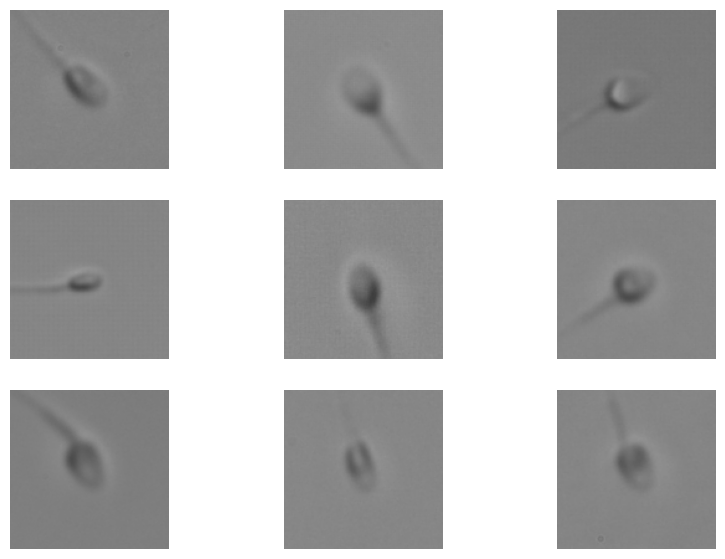

In [ ]:
fig = plt.figure(figsize=(10, 7))
for i in range(9):
  fig.add_subplot(3, 3, i+1)
  plt.axis('off')
  plt.imshow(torch.permute((val_set[i])[0], (1,2,0)), cmap="gray")

In [6]:
DEVICE = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(DEVICE)

cuda


In [7]:
model_number = 3 # int(input('Enter model number : 1.resnet50  2.vgg19  3.vgg19 (Miahi version) '))
model_name = ''

if model_number == 1 :
    from torchvision.models import resnet50
    convolutional_network = resnet50(weights=ResNet50_Weights.DEFAULT)
    convolutional_network  = nn.Sequential(*(list(convolutional_network.children())[:-1]))
    model_name = 'resnet50'
    method = "relational"
    model = RelationNetworks(convolutional_network, feature_dimension=2048).to(DEVICE)

elif model_number == 2 :
      from torchvision.models import vgg19
      model_name = 'vgg19'
      method = "relational"
      net = vgg19(weights=VGG19_Weights.DEFAULT)
      convolutional_network = net.features
      model = RelationNetworks(convolutional_network, feature_dimension=512).to(DEVICE)

elif model_number == 3 :
      from torchvision.models import vgg19
      from sperm.modules.predesigned_modules import relation_module
      method = "relational"
      model_name = 'vgg19(miahi)'
      net = vgg19(weights=VGG19_Weights.DEFAULT)
      convolutional_network  = nn.Sequential(*[net.features[i] for i in range(28)])
      relation_module = relation_module(feature_dimension= 512)
      model = RelationNetworks(convolutional_network, feature_dimension= 512, relation_module=relation_module).to(DEVICE)

elif model_number == 4 :
      method = "ooctye network"
      model_name = 'vgg16'
      feature_encoder = CNNEncoder()
      relation_network = RelationNetwork()
      relation_network.apply(weights_init)
      feature_encoder.to(DEVICE)
      relation_network.to(DEVICE)
      model = RelationNetworks(feature_encoder, feature_dimension= 512, relation_module=relation_network).to(DEVICE)

# print(relation_module)
print(convolutional_network)

Downloading: "https://download.pytorch.org/models/vgg19-dcbb9e9d.pth" to /root/.cache/torch/hub/checkpoints/vgg19-dcbb9e9d.pth
100%|██████████| 548M/548M [00:13<00:00, 43.8MB/s]


Sequential(
  (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (1): ReLU(inplace=True)
  (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (3): ReLU(inplace=True)
  (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (6): ReLU(inplace=True)
  (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (8): ReLU(inplace=True)
  (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (11): ReLU(inplace=True)
  (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (13): ReLU(inplace=True)
  (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (15): ReLU(inplace=True)
  (16): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (17): ReLU(inplace=True)
  (18): MaxPoo

In [13]:
feature_dimension = 512
inner_channels = 4096
net = nn.Sequential(
      nn.Sequential(
            nn.Conv2d(feature_dimension * 2,
                      feature_dimension,
                      kernel_size=3,
                      padding=1,
                      ),
            nn.BatchNorm2d(feature_dimension, momentum=1, affine=True),
            nn.ReLU(inplace=True),

            nn.Conv2d(feature_dimension,
                      feature_dimension,
                      kernel_size=3,
                      padding=1,
                      ),
            nn.BatchNorm2d(feature_dimension, momentum=1, affine=True),
            nn.ReLU(inplace=True),

            nn.Conv2d(feature_dimension,
                      feature_dimension,
                      kernel_size=3,
                      padding=1,
                      ),
            nn.BatchNorm2d(feature_dimension, momentum=1, affine=True),
            nn.ReLU(inplace=True),

            nn.Conv2d(feature_dimension,
                      feature_dimension,
                      kernel_size=3,
                      padding=1,
                      ),
            nn.BatchNorm2d(feature_dimension, momentum=1, affine=True),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False),
            nn.AdaptiveAvgPool2d(output_size=(7,7))
        ),
    nn.Sequential(
            nn.Flatten(),
            nn.Linear(in_features= 25088, out_features=inner_channels, bias= True),
            nn.Sigmoid(),
            nn.Dropout(p=0.9, inplace= False),
            nn.Linear(in_features= inner_channels, out_features= 1, bias= True),
            nn.Sigmoid(),
  ),
)

In [14]:
from torchvision import models
from torchsummary import summary
summary(net.to(DEVICE), (1024,8,8))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1            [-1, 512, 8, 8]       4,719,104
       BatchNorm2d-2            [-1, 512, 8, 8]           1,024
              ReLU-3            [-1, 512, 8, 8]               0
            Conv2d-4            [-1, 512, 8, 8]       2,359,808
       BatchNorm2d-5            [-1, 512, 8, 8]           1,024
              ReLU-6            [-1, 512, 8, 8]               0
            Conv2d-7            [-1, 512, 8, 8]       2,359,808
       BatchNorm2d-8            [-1, 512, 8, 8]           1,024
              ReLU-9            [-1, 512, 8, 8]               0
           Conv2d-10            [-1, 512, 8, 8]       2,359,808
      BatchNorm2d-11            [-1, 512, 8, 8]           1,024
             ReLU-12            [-1, 512, 8, 8]               0
        MaxPool2d-13            [-1, 512, 4, 4]               0
AdaptiveAvgPool2d-14            [-1, 51

In [ ]:
n_way = 2
n_shot = 64
n_query = 64
n_workers = 2

n_train_tasks = 100
n_validation_tasks = 100

train_sampler = TaskSampler(
    train_set, n_way=n_way, n_shot=n_shot, n_query=n_query, n_tasks=n_train_tasks
)

n_shot_val = 64
n_query_val = 64

val_sampler = TaskSampler(
    val_set, n_way=n_way, n_shot=n_shot_val, n_query=n_query_val, n_tasks=n_validation_tasks
)

train_loader = DataLoader(
    train_set,
    batch_sampler=train_sampler,
    num_workers=n_workers,
    pin_memory=True,
    collate_fn=train_sampler.episodic_collate_fn,
)

val_loader = DataLoader(
    val_set,
    batch_sampler=val_sampler,
    num_workers=n_workers,
    pin_memory=True,
    collate_fn=val_sampler.episodic_collate_fn,
)

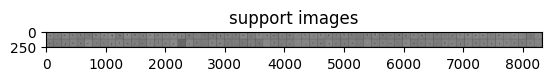

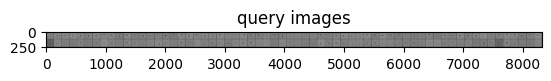

In [ ]:
(example_support_images,
 example_support_labels,
 example_query_images,
 example_query_labels,
 example_class_ids,
) = next(iter(train_loader))

plot_images(example_support_images, "support images", images_per_row=n_shot)
plot_images(example_query_images, "query images", images_per_row=n_query)


In [ ]:
from torch.optim import SGD
from torch.optim.lr_scheduler import MultiStepLR
from torch.utils.tensorboard import SummaryWriter

n_epochs = 100
tb_logs_dir = Path("./events/")
best_epoch = 90
saved_model_path = str("./%s/%s" % ("/drive/MyDrive/Colab Notebooks/sperm/trained-models", str(best_epoch)) + ".pkl")
#saved_model_path = str("./%s/%s" % ("/drive/MyDrive/Colab Notebooks/sperm/best-models/687-689", str(best_epoch)) + "_best.pkl")

if os.path.exists(saved_model_path):
    model.load_state_dict(torch.load(saved_model_path, map_location=torch.device(DEVICE)))
    print("model loaded succesfully")

loss = "cross entropy"
LOSS_FUNCTION = nn.CrossEntropyLoss()

optimizer = "SGD"
learning_rate = 1e-3
train_optimizer = SGD(model.parameters(), lr=learning_rate, momentum=0.9, weight_decay=5e-4)

train_scheduler = MultiStepLR(
    train_optimizer,
    milestones=[120, 130],
    gamma=0.1,
)

tb_writer = SummaryWriter(log_dir=str(tb_logs_dir))

model loaded succesfully


In [ ]:
best_state = model.state_dict()
best_val_accuracy = 0.0
train_loss_list = []
valid_acc_list = []
start_time = time.time()

for epoch in range(best_epoch, n_epochs):
    print(f"Epoch {epoch}")
    train_loss = train(model, train_loader, train_optimizer, LOSS_FUNCTION, DEVICE )
    val_accuracy,_,_,_,_ = evaluate(model, val_loader, device=DEVICE, tqdm_prefix="Validation")

    valid_acc_list.append(val_accuracy)
    train_loss_list.append(train_loss)

    if val_accuracy > best_val_accuracy:
        best_val_accuracy = val_accuracy
        best_state = model.state_dict()
        torch.save(best_state, str("./%s/%s_best" % ("/drive/MyDrive/Colab Notebooks/sperm/trained-models", str(epoch)) + ".pkl"),)
        print("Ding ding ding! We found a new best model!")

    if epoch != (n_epochs - 1) :
        rows = [[train_loss], [val_accuracy], [''], [''], [''], [''], [''], [''], [''], [''], [''], [''], [''], [''], [''], [''], [''], ['']]
        save_result(rows = rows)

    if epoch % 10 == 0:
      torch.save(best_state, str("./%s/%s" % ("/drive/MyDrive/Colab Notebooks/sperm/trained-models", str(epoch)) + ".pkl"),)

    # tb_writer.add_scalar("Train/loss", train_loss, epoch)
    # tb_writer.add_scalar("Val/acc", val_accuracy, epoch)

    train_scheduler.step()

train_time = time.time() - start_time
model.load_state_dict(best_state)

Epoch 90


/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
Validation: 100%|██████████| 100/100 [01:11<00:00,  1.39it/s, accuracy=0.752]


Ding ding ding! We found a new best model!
Epoch 91


/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
Training: 100%|██████████| 100/100 [02:12<00:00,  1.32s/it, loss=0.354]/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
Validation: 100%|██████████| 100/100 [01:11<00:00,  1.39it/s, accuracy=0.751]


Epoch 92


/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
Training: 100%|██████████| 100/100 [02:12<00:00,  1.32s/it, loss=0.359]/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
Validation: 100%|██████████| 100/100 [01:11<00:00,  1.39it/s, accuracy=0.769]


Ding ding ding! We found a new best model!
Epoch 93


/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
Training: 100%|██████████| 100/100 [02:12<00:00,  1.31s/it, loss=0.356]/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
Validation: 100%|██████████| 100/100 [01:11<00:00,  1.40it/s, accuracy=0.752]


Epoch 94


/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
Training: 100%|██████████| 100/100 [02:12<00:00,  1.32s/it, loss=0.355]/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
Validation: 100%|██████████| 100/100 [01:12<00:00,  1.39it/s, accuracy=0.747]


Epoch 95


/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
Training: 100%|██████████| 100/100 [02:12<00:00,  1.32s/it, loss=0.354]/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
Validation: 100%|██████████| 100/100 [01:11<00:00,  1.39it/s, accuracy=0.756]


Epoch 96


/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
Training: 100%|██████████| 100/100 [02:12<00:00,  1.32s/it, loss=0.354]/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
Validation: 100%|██████████| 100/100 [01:11<00:00,  1.39it/s, accuracy=0.754]


Epoch 97


/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
Training: 100%|██████████| 100/100 [02:12<00:00,  1.31s/it, loss=0.354]/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
Validation: 100%|██████████| 100/100 [01:11<00:00,  1.40it/s, accuracy=0.753]


Epoch 98


/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
Training: 100%|██████████| 100/100 [02:12<00:00,  1.32s/it, loss=0.356]/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
Validation: 100%|██████████| 100/100 [01:11<00:00,  1.39it/s, accuracy=0.746]


Epoch 99


/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
Training: 100%|██████████| 100/100 [02:12<00:00,  1.32s/it, loss=0.357]/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
Validation: 100%|██████████| 100/100 [01:12<00:00,  1.38it/s, accuracy=0.753]


<All keys matched successfully>

In [ ]:
#plotting
# plt.subplot(2, 1, 1)
# plt.plot([*range(n_epochs)], train_loss_list, color='#FF8C00')

# plt.ylabel("train loss")

# plt.subplot(2, 1, 2)
# plt.plot([*range(n_epochs)], valid_acc_list, color='#4682B4')

# plt.xlabel("Epochs")
# plt.ylabel("valid accuracy")
# plt.show()

In [ ]:
saved_model_path = str("./%s/%s" % ("/drive/MyDrive/Colab Notebooks/sperm/trained-models/", str(66)) + "_best.pkl")
model.load_state_dict(torch.load(saved_model_path, map_location=torch.device(DEVICE)))

<All keys matched successfully>

In [ ]:
test_label = 'h'
n_test_tasks = 100
params = {'balancer':True, 'image_size': 128}

test_set  = MHSMA(dtype ="test", label = test_label, params=params)
# test_set  = normalize(test_set)

n_shot = 64
n_query = 64
n_way = 2
n_workers = 2

test_sampler = TaskSampler(
    test_set, n_way=n_way, n_shot=n_shot, n_query=n_query, n_tasks=n_test_tasks
)

test_loader = DataLoader(
    test_set,
    batch_sampler=test_sampler,
    num_workers=n_workers,
    pin_memory=True,
    collate_fn=test_sampler.episodic_collate_fn,
)

In [ ]:
accuracy, TP, TN, FP, FN = evaluate(model, test_loader, device=DEVICE)
print(f"Average accuracy : {(100 * accuracy):.2f} %")

prec = precision(TP, FP)
rec = recall(TP, FN)
dsc_var = dsc(TP, FP, FN)

print("precision: ", prec)
print("recall: ",rec)
print("DSC: ",dsc_var)

rows = [[train_loss], [best_val_accuracy], [accuracy], [n_shot], [n_query], [n_train_tasks],
[n_validation_tasks], [n_test_tasks], [train_val_label], [train_val_label], [test_label], [model_name], [method], [learning_rate], [loss], [prec], [rec], [dsc_var]]

save_result(rows = rows)

100%|██████████| 100/100 [01:07<00:00,  1.48it/s, accuracy=0.717]

Average accuracy : 71.67 %
precision:  0.7034917840375586
recall:  0.74921875
DSC:  0.725635593220339


NameError: name 'train_loss' is not defined

In [ ]:
test_label = 'v'
n_test_tasks = 100
params = {'balancer':True, 'image_size': 128}

test_set  = MHSMA(dtype ="test", label = test_label, params=params)
# test_set  = normalize(test_set)

n_shot = 64
n_query = 64
n_way = 2
n_workers = 2

test_sampler = TaskSampler(
    test_set, n_way=n_way, n_shot=n_shot, n_query=n_query, n_tasks=n_test_tasks
)

test_loader = DataLoader(
    test_set,
    batch_sampler=test_sampler,
    num_workers=n_workers,
    pin_memory=True,
    collate_fn=test_sampler.episodic_collate_fn,
)

In [ ]:
accuracy, TP, TN, FP, FN = evaluate(model, test_loader, device=DEVICE)
print(f"Average accuracy : {(100 * accuracy):.2f} %")

prec = precision(TP, FP)
rec = recall(TP, FN)
dsc_var = dsc(TP, FP, FN)

print("precision: ", prec)
print("recall: ",rec)
print("DSC: ",dsc_var)

rows = [[train_loss], [best_val_accuracy], [accuracy], [n_shot], [n_query], [n_train_tasks],
[n_validation_tasks], [n_test_tasks], [train_val_label], [train_val_label], [test_label], [''], [''], [''], [''],  [prec], [rec], [dsc_var]]

save_result(rows = rows)

100%|██████████| 100/100 [01:07<00:00,  1.49it/s, accuracy=0.831]

Average accuracy : 83.06 %
precision:  0.8721421034118888
recall:  0.77484375
DSC:  0.8206188978983948


NameError: name 'train_loss' is not defined

In [ ]:
test_label = 'a'
n_test_tasks = 100
params = {'balancer':True, 'image_size': 128}

test_set  = MHSMA(dtype ="test", label = test_label, params=params)
# test_set  = normalize(test_set)

n_shot = 64
n_query = 64
n_way = 2
n_workers = 2

test_sampler = TaskSampler(
    test_set, n_way=n_way, n_shot=n_shot, n_query=n_query, n_tasks=n_test_tasks
)

test_loader = DataLoader(
    test_set,
    batch_sampler=test_sampler,
    num_workers=n_workers,
    pin_memory=True,
    collate_fn=test_sampler.episodic_collate_fn,
)

In [ ]:
accuracy, TP, TN, FP, FN = evaluate(model, test_loader, device=DEVICE)
print(f"Average accuracy : {(100 * accuracy):.2f} %")

prec = precision(TP, FP)
rec = recall(TP, FN)
dsc_var = dsc(TP, FP, FN)

print("precision: ", prec)
print("recall: ",rec)
print("DSC: ",dsc_var)

rows = [[train_loss], [best_val_accuracy], [accuracy], [n_shot], [n_query], [n_train_tasks],
[n_validation_tasks], [n_test_tasks], [train_val_label], [train_val_label], [test_label], [''], [''], [''], [''],  [prec], [rec], [dsc_var]]

save_result(rows = rows)

100%|██████████| 100/100 [01:07<00:00,  1.48it/s, accuracy=0.717]

Average accuracy : 71.71 %
precision:  0.6993257782240712
recall:  0.76171875
DSC:  0.7291900381422481


NameError: name 'train_loss' is not defined